In [111]:
import plot_function
from importlib import reload
reload(plot_function)
from plot_function import *

import matplotlib
matplotlib.pyplot.ion()
%config InlineBackend.figure_formats = ['svg']
sns.set_theme(style="whitegrid")
# sns.set_theme(style="white")
sns.set_palette("colorblind")

import matplotlib.pyplot as plt
FONT_SIZE=10
plt.rcParams['axes.labelsize'] = FONT_SIZE
plt.rcParams['xtick.labelsize'] = FONT_SIZE
plt.rcParams['ytick.labelsize'] = FONT_SIZE
plt.rcParams['legend.fontsize'] = FONT_SIZE
plt.rcParams['font.size'] = FONT_SIZE
plt.rcParams['legend.title_fontsize'] = FONT_SIZE
# plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.family'] = 'times'
plt.rcParams['font.serif'] = ['Computer Modern Roman']
plt.rcParams['text.usetex'] = True

In [112]:
job_details_template = {
    "scrap_measurement_overhead": {
        "id": 694
    },
    "scrap_measurement_overhead_2": {
        "id": 857
    },
    "moon": {
        "id": 804, # 3 Clients crashed,
        "dev_order": ["jao1", "jao2", "jon1", "jon2", "jon3", "jon4", "jxn1", "jxn2", "jn5", "jn6"],
        "dev_type_order": ["AGXOrin", "OrinNano", "XavierNX", "Nano"],
        "data_batches": [82, 57, 69, 78, 81, 59, 81, 67, 126, 76],
        "epochs": 10,
    },
    "moon_fedprox": {
        "id": 808,
        "max_round": 30,
        "inherits": "moon",
    },
    "moon_large_model": {
        "id": 831, # confirm
        "dev_order": ["jao1", "jao2", "jon1", "jon2", "jon3", "jon4", "jxn1", "jxn2"],
        "dev_type_order": ["AGXOrin", "OrinNano", "XavierNX"],
        "data_batches": [115, 31, 102, 71, 114, 129, 127, 89],
        "max_round": 30, # max 31
        "epochs": 10,
    },
    "moon_large_model_opt": {
        "id": 832,
        "max_round": 30, # max 45
        "inherits": "moon_large_model",
    },
    "moon_fedprox_large_model_opt": {
        "id": 833,
        "max_round": 30, # max 48
        "inherits": "moon_large_model",
    },
    "test": {
        "id": 809
    },
}

def expand_inherits(job_details_template):
    expanded_data = {}

    for exp_name, job_details in job_details_template.items():
        if 'inherits' in job_details:
            inherited_job = job_details['inherits']
            expanded_details = {**job_details_template[inherited_job], **job_details}
            expanded_details.pop('inherits', None)
            expanded_data[exp_name] = expanded_details
        else:
            expanded_data[exp_name] = job_details

        # Add exp_name as field for exp
        expanded_data[exp_name]['exp_name'] = exp_name

    return expanded_data

job_details_map = expand_inherits(job_details_template)

Data samples was not specified, will not compute per sample columns


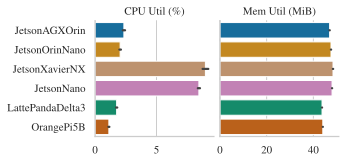

In [139]:
exp_name="scrap_measurement_overhead"
# exp_name="scrap_measurement_overhead_2"
job_details = job_details_map[exp_name]
job_data = collect_job_metrics(job_details)

# Adjust units
hw_metrics = job_data["hw_metrics"]
hw_metrics["Sent (KiB)"] = hw_metrics["Sent (MiB)"] * 1024
hw_metrics["Rcvd (KiB)"] = hw_metrics["Rcvd (MiB)"] * 1024
hw_metrics["Upload (KiB/s)"] = hw_metrics["Upload (MiB/s)"] * 1024
hw_metrics["Download (KiB/s)"] =  hw_metrics["Download (MiB/s)"]  * 1024

import plot_function
from importlib import reload
reload(plot_function)
from plot_function import *
job_data["hw_metrics"].rename(columns={
    "CPU Util (%)": "CPU Util (\%)"
}, inplace=True)

# df = job_data["hw_metrics"][["device_type", "CPU Util (%)", "Mem Util (MiB)", "Power (W)"]]
df = job_data["hw_metrics"][["device_type", "CPU Util (\%)", "Mem Util (MiB)"]]
plot_hw_metrics(df, save_name="scrape_hw_1.pdf")

# df = job_data["hw_metrics"][["device_type", "Sent (MiB)", "Rcvd (MiB)", "Upload (MiB/s)", "Download (MiB/s)"]]
# df = job_data["hw_metrics"][["device_type", "Sent (KiB)", "Rcvd (KiB)", "Upload (KiB/s)", "Download (KiB/s)"]]
# plot_hw_metrics(df, save_name="scrape_hw_2.pdf")


In [ ]:
job_details = job_details_map["test"]
job_data = collect_job_metrics(job_details)
order = ["JetsonAGXOrin", "JetsonOrinNano"]
plot_cir_metrics(job_data["cr_timings"], job_details, order=order)

In [ ]:
job_details = job_details_map["moon"]
moon_job_data = collect_job_metrics(job_details)
full_algo_plot(moon_job_data["cr_timings"], job_details)

In [ ]:
job_details = job_details_map["moon_fedprox"]
moon_fedprox_job_data = collect_job_metrics(job_details)
full_algo_plot(moon_fedprox_job_data["cr_timings"], job_details)

In [ ]:
job_details = job_details_map["moon_large_model"]
moon_job_data = collect_job_metrics(job_details)
full_algo_plot(moon_job_data["cr_timings"], job_details, show=False)

In [ ]:
job_details = job_details_map["moon_large_model_opt"]
moon_job_data = collect_job_metrics(job_details)
full_algo_plot(moon_job_data["cr_timings"], job_details, show=False)

In [ ]:
job_details = job_details_map["moon_fedprox_large_model_opt"]
moon_job_data = collect_job_metrics(job_details)
full_algo_plot(moon_job_data["cr_timings"], job_details, show=False)

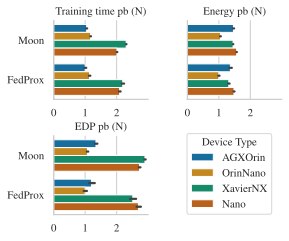

In [133]:
# algorithms = [
#     ("moon", "Moon"),
#     ("moon_fedprox", "FedProx"),
# ]

# algorithms_to_cmp = []
# for job_name, algorithm_title in algorithms:
#     job_details = job_details_map[job_name]
#     job_data = collect_job_metrics(job_details)["cr_timings"]
#     job_data["Algorithm"] = algorithm_title
#     algorithms_to_cmp.append(job_data)
import plot_function
from importlib import reload
reload(plot_function)
from plot_function import *
cmp_algorithms_by_cir(algorithms_to_cmp, "device_type", perb=True, save_file="cmp_moon_fedprox_orig.pdf")

In [119]:
algorithms = [
    ("moon_large_model", "Moon (L)"),
    ("moon_large_model_opt", "Moon (L+O)"),
    ("moon_fedprox_large_model_opt", "Fedprox (L)"),
]

algorithms_to_cmp = []
for job_name, algorithm_title in algorithms:
    job_details = job_details_map[job_name]
    job_data = collect_job_metrics(job_details)["cr_timings"]
    job_data["Algorithm"] = algorithm_title
    algorithms_to_cmp.append(job_data)

# import plot_function
# from importlib import reload
# reload(plot_function)
# from plot_function import *

# cmp_algorithms_by_cir(algorithms_to_cmp, "device_type", perb=True, save_file="cmp_moon_fedprox_large.pdf")

Clipping rounds to 30
Clipping rounds to 30
Clipping rounds to 30


In [ ]:
import plot_function
from importlib import reload
reload(plot_function)
from plot_function import *

cmp_algorithms_by_cir(algorithms_to_cmp, "device_type", perb=True, save_file="cmp_moon_fedprox_large.pdf")
# cmp_algorithms_by_cir(algorithms_to_cmp, "device_type", perb=True, save_file="cmp_moon_fedprox_large_per_algorithm.pdf")

            Round time (N)                                                    \
                     count      mean       std       min       25%       50%   
Algorithm                                                                      
Fedprox (L)          238.0  1.000000  0.053578  0.671483  1.006562  1.007066   
Moon (L)             237.0  1.836293  0.072557  1.349594  1.842799  1.845121   
Moon (L+O)           234.0  1.211370  0.052156  0.665884  1.212126  1.213514   

                                Energy in round (N)                      \
                  75%       max               count      mean       std   
Algorithm                                                                 
Fedprox (L)  1.007504  1.052340               238.0  1.000000  0.075926   
Moon (L)     1.847054  1.907143               237.0  1.872533  0.140035   
Moon (L+O)   1.216075  1.278531               234.0  1.242464  0.095115   

                                                               
    

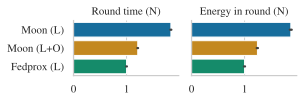

In [120]:
import plot_function
from importlib import reload
reload(plot_function)
from plot_function import *

comp_algorithms_by_round_metrics(algorithms_to_cmp, save_file="high_level_algorithm_cmp_large.pdf")

In [ ]:
cmp_algorithms_by_cir(algorithms_to_cmp, "device_name", perb=True, save_file="cmp_moon_fedprox_large_per_dev.pdf")

In [ ]:

job_data["hw_metrics"].groupby(['client_id', 'round_number', 'stage']).describe()

In [ ]:
job_data["hw_metrics"].groupby("device_name").mean(numeric_only=True)